# Intro

this is a notebook I wrote as notes when reading
https://towardsdatascience.com/ab-testing-with-python-e5964dd66143
The idea was to follow the article and code along at the same time. 

Dataset comes from kaggle (4 MB)
https://www.kaggle.com/datasets/zhangluyuan/ab-testing?select=ab_data.csv


#### TLDR of the case
current avg conversion rate is 13% (no info on variance which I think should be a factor when deciding what is "success")
but still the success is defined as increasing the avg conversion rate to 15%. 

author decides to make a two-tailed test with the motivation that we don't know if the design will perform better or worse. My take is that the since we're interested in knowing if we maybe improve conversion rate to 15% we should do a one tailed z-test. anyways, I'll follow the article first and then make my own take in the end.     

choosing alpha=0.05

there's a control group and a treatment group

conversion is captured as a binary variable 0-did not buy during session, 1-did buy during session



# imports

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

from statsmodels.stats.proportion import proportions_ztest, proportion_confint

from datetime import datetime
import altair as alt
from scipy.stats import ttest_ind

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### choosing sample size

#### power of test (1-beta)
probability of finding a statistical deifference between the groups in the test when there really is a difference. 
here beta was set to 0.2 --> power=0.8

#### alpha
was chosen as 0.05

#### effect size
expected difference between the conversion rates. base_avg = 0.13. expected_avg=0.15

In [2]:
base_avg = 0.13 
expected_avg= 0.15
alpha=0.05
beta=0.2

In [3]:
effect_size = sms.proportion_effectsize(base_avg, expected_avg)
print('The effect size is %.4f'  % effect_size)


The effect size is -0.0577


In [4]:
required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=(1-beta), 
    alpha=alpha, 
    ratio=1
    ) 

required_n = ceil(required_n)

print('The sample size for each group is %d' % required_n)

The sample size for each group is 4720


# Get data

In [5]:
df = pd.read_csv('data/ab_data.csv')

In [6]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


### notes
the author decided to check for users that are sampled multiple times in the data set and removes those

In [8]:
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print('There are %d users that appear multiple times in the dataset' % multi_users)

There are 3894 users that appear multiple times in the dataset


In [9]:
users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {df.shape[0]} entries')

The updated dataset now has 286690 entries


# make the sampling

as in the article

In [10]:
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

ab_test

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
9435,908512,2017-01-14 22:02:29.922674,treatment,new_page,0
9436,873211,2017-01-05 00:57:16.167151,treatment,new_page,0
9437,631276,2017-01-20 18:56:58.167809,treatment,new_page,0
9438,662301,2017-01-03 08:10:57.768806,treatment,new_page,0


In [11]:
ab_test.group.value_counts()

control      4720
treatment    4720
Name: group, dtype: int64

In [12]:
ab_test.groupby('group').converted.describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
control,4720.0,0.123305,0.328822,0.0,0.0,0.0,0.0,1.0
treatment,4720.0,0.125636,0.331473,0.0,0.0,0.0,0.0,1.0


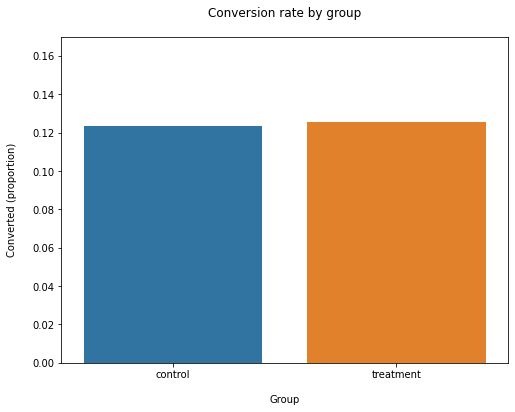

In [13]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

# Testing

z-test

In [14]:
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

In [15]:
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

In [16]:
z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.34
p-value: 0.732
ci 95% for control group: [0.114, 0.133]
ci 95% for treatment group: [0.116, 0.135]


# my own lil take 
after having watched the AB testing lecture on 365 data science. 

In [17]:
# first just reaload the data 
df = pd.read_csv('data/ab_data.csv')

In [18]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [20]:
#cast as datetime
df.timestamp = pd.to_datetime(df.timestamp)
# remove the time part and just keep date
df_clean = df.copy()

df_clean.timestamp = df_clean.timestamp.dt.date

In [21]:
# #try this if you don't want to use pandas timestamp

# df_clean.timestamp = df_clean.timestamp.map(lambda x: datetime.strptime(x, '%Y-%m-dT%H:%M:%SZ').strftime('%Y-%m-%d'))

In [22]:
df_clean.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21,control,old_page,0
1,804228,2017-01-12,control,old_page,0
2,661590,2017-01-11,treatment,new_page,0
3,853541,2017-01-08,treatment,new_page,0
4,864975,2017-01-21,control,old_page,1


In [23]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [24]:
df_clean.groupby('group').converted.describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
control,147202.0,0.120399,0.325429,0.0,0.0,0.0,0.0,1.0
treatment,147276.0,0.118920,0.323695,0.0,0.0,0.0,0.0,1.0


In [25]:
users = df_clean.groupby(['timestamp','group']).count().reset_index()

In [26]:
#cast as datetime
users.timestamp = pd.to_datetime(users.timestamp)

In [27]:
users.head()

,timestamp,group,user_id,landing_page,converted
0,2017-01-02,control,2894,2894,2894
1,2017-01-02,treatment,2889,2889,2889
2,2017-01-03,control,6684,6684,6684
3,2017-01-03,treatment,6710,6710,6710
4,2017-01-04,control,6655,6655,6655


In [28]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     46 non-null     datetime64[ns]
 1   group         46 non-null     object        
 2   user_id       46 non-null     int64         
 3   landing_page  46 non-null     int64         
 4   converted     46 non-null     int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 1.9+ KB


In [29]:
alt.Chart(users).mark_line(size=1).encode(
    alt.X('timestamp:T', axis=alt.Axis(title='date')),
    alt.Y('user_id:Q', axis=alt.Axis(title='number users')),
    tooltip=['group'],
    color='group:N'
).properties(
    width=600,
    height=400
)

alt.Chart(...)

# active users who bought

In [30]:
df_active=df_clean.copy()

In [31]:
#cast as datetime
df_active.timestamp = pd.to_datetime(df_active.timestamp)
df_active.timestamp = df_active.timestamp.dt.date
df_active.timestamp = pd.to_datetime(df_active.timestamp)

In [32]:
df_active.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       294478 non-null  int64         
 1   timestamp     294478 non-null  datetime64[ns]
 2   group         294478 non-null  object        
 3   landing_page  294478 non-null  object        
 4   converted     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


In [33]:
df_active.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21,control,old_page,0
1,804228,2017-01-12,control,old_page,0
2,661590,2017-01-11,treatment,new_page,0
3,853541,2017-01-08,treatment,new_page,0
4,864975,2017-01-21,control,old_page,1


In [34]:
active = df_active.groupby(['timestamp','group','converted']).count().reset_index()
active.head()

,timestamp,group,converted,user_id,landing_page
0,2017-01-02,control,0,2532,2532
1,2017-01-02,control,1,362,362
2,2017-01-02,treatment,0,2541,2541
3,2017-01-02,treatment,1,348,348
4,2017-01-03,control,0,5924,5924


In [35]:
active_conv = active.loc[active.converted != 0]
active_conv.head()

,timestamp,group,converted,user_id,landing_page
1,2017-01-02,control,1,362,362
3,2017-01-02,treatment,1,348,348
5,2017-01-03,control,1,760,760
7,2017-01-03,treatment,1,762,762
9,2017-01-04,control,1,810,810


In [36]:
alt.Chart(active_conv).mark_line(size=1).encode(
    alt.X('timestamp:T', axis=alt.Axis(title='date')),
    alt.Y('user_id:Q', axis=alt.Axis(title='number users who converted')),
    tooltip=['group'],
    color='group:N'
).properties(
    width=600,
    height=400
)

alt.Chart(...)

In [37]:
active_conv.groupby('group').user_id.describe().transpose()

group,control,treatment
count,23.000000,23.000000
mean,770.565217,761.478261
std,118.518056,119.746653
min,362.000000,348.000000
25%,778.500000,767.000000
50%,805.000000,794.000000
75%,817.000000,817.000000
max,859.000000,858.000000


# Grab a sample

In [38]:
def binomial_sample_size(metric, mde, alpha, beta):
    #std normal distribution to determine z-values
    snd = stats.norm(0,1)

    Z_beta = snd.ppf(1-beta)
    Z_alpha = snd.ppf(1-alpha/2)

    #avg of probabilities from both groups
    p = (metric + metric+mde)/2

    N=(2 * p *(1-p)*(Z_beta + Z_alpha)**2 / mde**2)

    return N

In [39]:
metric=0.13
mde=0.02
alpha=0.05
beta= 0.2

sample_size= binomial_sample_size(metric, mde, alpha, beta)

sample_size = ceil(sample_size)

print('binom sample size is %f' % sample_size)

binom sample size is 4726.000000


In [40]:
control_sample = df_clean.loc[df_clean.group=='control'].sample(n=sample_size, random_state=22)
treatment_sample = df_clean.loc[df_clean.group=='treatment'].sample(n=sample_size, random_state=22)


In [41]:
control_sample.head()

,user_id,timestamp,group,landing_page,converted
254532,644179,2017-01-16,control,old_page,0
196706,729672,2017-01-20,control,old_page,0
272726,866186,2017-01-09,control,old_page,0
118044,884303,2017-01-18,control,old_page,0
205159,882576,2017-01-15,control,old_page,0


# Compare

In [42]:
res = ttest_ind(control_sample.converted.to_numpy(),
                treatment_sample.converted.to_numpy()
               ).pvalue

print('p-val is: %.5f' % res)

p-val is: 0.89871


# looking at the whole pop and users who bought per day

In [43]:
active_conv.head()

,timestamp,group,converted,user_id,landing_page
1,2017-01-02,control,1,362,362
3,2017-01-02,treatment,1,348,348
5,2017-01-03,control,1,760,760
7,2017-01-03,treatment,1,762,762
9,2017-01-04,control,1,810,810


In [44]:
res = ttest_ind(active_conv.loc[active_conv.group=='control']['user_id'].to_numpy(),
                active_conv.loc[active_conv.group=='treatment']['user_id'].to_numpy()
               ).pvalue

print('p-val is: %.5f' % res)

p-val is: 0.79710


# Sample size Stuff

In [45]:
def binomial_sample_size(metric, mde, alpha, beta):
    #std normal distribution to determine z-values
    snd = stats.norm(0,1)

    Z_beta = snd.ppf(1-beta)
    Z_alpha = snd.ppf(1-alpha/2)

    #avg of probabilities from both groups
    p = (metric + metric+mde)/2

    N=(2 * p *(1-p)*(Z_beta + Z_alpha)**2 / mde**2)

    return N

In [46]:
def continous_sample_size(metric, mde, sd, alpha, beta):
    #std normal distribution to determine z-values
    snd = stats.norm(0,1)

    Z_beta = snd.ppf(1-beta)
    Z_alpha = snd.ppf(1-alpha/2)
    print(Z_beta, '\n', Z_alpha)
    
    N=(2 * sd**2 * (Z_beta + Z_alpha)**2 / mde**2)

    return N

In [47]:
metric=0.13
mde=0.02
alpha=0.05
beta= 0.2

sample_size= binomial_sample_size(metric, mde, alpha, beta)

print('binom sample size is %f' % sample_size)

binom sample size is 4725.025600


In [48]:
metric=30673
mde=100
sd=91
alpha=0.05
beta= 0.2

sample_size= continous_sample_size(metric, mde,sd, alpha, beta)

print('cont sample size is %f' % sample_size)

0.8416212335729143 
 1.959963984540054
cont sample size is 12.999315


# exam test